In [1]:
import uproot
import pandas as pd
import sys,os, time, glob, re  
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.auto import tqdm       
tqdm.pandas()

# import the custom python module
import muonfixedid, chamberlist_run3   
import splitter_regions_Run2
import mdtCalib_functions

inputCalibNtuple='data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0120.ntuple.root'
f=uproot.open(inputCalibNtuple)  


In [2]:
tree=f['Segments']                                     
run = inputCalibNtuple.split('0',1)[1][:6]        
region = int(inputCalibNtuple.split("-", 1)[1][:4])
lb = inputCalibNtuple.split("-", 1)[0][-9:]          
branchList=tree.keys()                                  
branchPrefix=['trk', 'trkHit', 'event', 'rawMdt']       
branchMapping={key : [] for key in branchPrefix}          # branchMapping is a dictionary

for branch in branchList:
    branchName, variableName= branch.split('_', 1)
    if branchName in branchPrefix:
        branchMapping[branchName].append(branch)
        
# convert mdtCalname to mdtHardname by chamberlist.py
chamberInRegion = [chamberlist_run3.MDThardname(chamberlist_run3.MDTindex(x)) for x in splitter_regions_Run2.regionlist[region]]
print('process run %s lumiblock %s region %s, chamberList %s' % (run, lb, region, chamberInRegion))

process run 045672 lumiblock 0000_0004 region 120, chamberList ['IsWRONG', 'BIS7A16', 'EES1A16', 'EES2A16', 'EMS4A16', 'EMS5A16']


In [3]:
import awkward as ak  
df_raw=ak.to_dataframe(tree.arrays(branchMapping['rawMdt']))  #converted awkwad array to dataframe

# expand all raw and trk hits with correct chamberName and tubeInfo
df_raw['rawMdt_tubeInfo'] = df_raw['rawMdt_id'].apply(lambda x : chamberlist_run3.MDTtubename(int(x)))
df_raw['rawMdt_station'] = df_raw['rawMdt_tubeInfo'].apply(lambda x :x[:7])
df_raw['rawMdt_type'] = df_raw['rawMdt_tubeInfo'].apply(lambda x :x[:3])
print(df_raw.head(5))

df_all = tree.arrays() #gives total numner of events and not hits
total_evts=len(df_all)

print(f'Total Event in this file is {total_evts}')

                rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
0     0                 99   4114.294922  -1704.196777   9544.875000   
      1                111   4114.294922  -1704.196777   9454.769531   
      2                148   4114.294922  -1704.196777   9424.735352   
      3                198   4114.294922  -1704.196777   9094.349609   
      4                 92   4090.263916  -1694.242798   9469.787109   

                rawMdt_id  rawMdt_nRMdt  rawMdt_tdc rawMdt_tubeInfo  \
entry subentry                                                        
0     0         105446809            45        1055  BEE1A16-1-4-26   
      1         105446806            45        1172  BEE1A16-1-4-23   
      2         105446805            45         489  BEE1A16-1-4-22   
      3         105446794            45         724  BEE1A16-1-4-11   
      4         105446678            45        1207  BEE1A16-1-3-23  

# Tube_index and noise_rate dataframe

In [4]:
#tube_id gives the tube index
def tube_id(row, chamber): 
    # Grab the tube name
    x = row[0]
    # Split into components that were separated by a '-'
    ml_index=int(x.split('-')[1])
    ly_index =int(x.split('-')[2])
    tube_no =int(x.split('-')[3])

    # Calculate unique tube id 
    return (ml_index-1)*chamberlist_run3.MDTnTml(chamber,1) + (ly_index-1)*chamberlist_run3.MDTnTly(chamber,ml_index) + tube_no

act_time_window=1.3*(10**(-6))
total_evts  

#Noise rate
def noise_rate(df, chamber):
    df_raw_chamber = df[df['rawMdt_station']==chamber]

    # Aggregate tube hits with pandas value_counts() method
    tube_hits=df_raw_chamber.rawMdt_tubeInfo.value_counts()

    # Recalculate all noise_rates and construct them into a new Series
    noise_rate=tube_hits/(act_time_window*total_evts)
    
    # Convert to dataframe
    noise_rate_df = noise_rate.reset_index()
    
    # Add column names to two columns
    noise_rate_df.columns = ['Tube_Name', 'Noise_Rate']
    
    # Create new column for tube ids and calculate each id inline in the tube_id() function
    noise_rate_df['Tube_ID'] = noise_rate_df.apply(lambda row: tube_id(row, chamber), axis=1)
    
    return noise_rate_df #returns a dataframe
    
df_noise_rate=noise_rate(df_raw,'BIS7A16')
df_noise_rate

/var/folders/w3/c0s4x6mj0rd2h643_w1y144r0000gn/T/ipykernel_97935/347346230.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = row[0]


,Tube_Name,Noise_Rate,Tube_ID
0,BIS7A16-2-4-49,493554.980179,601
1,BIS7A16-2-4-16,299167.309498,568
2,BIS7A16-2-4-15,246987.235808,567
3,BIS7A16-2-4-84,238713.932476,636
4,BIS7A16-2-4-83,202427.923214,635
...,...,...,...
642,BIS7A16-2-2-92,1281.779389,452
643,BIS7A16-2-1-12,186.440638,276
644,BIS7A16-2-1-11,116.525399,275
645,BIS7A16-2-4-1,93.220319,553


In [7]:
adc_cut=50
df_raw_chamber_with_adc_cut=df_raw_chamber[df_raw_chamber['rawMdt_adc']>adc_cut]
df_noise_rate_with_adc_cut = df_noise_rate(df_new_adc_cut,'BIS7A16')
df_noise_rate_with_adc_cut
# plot_for_noise_rate(extracted_df)

NameError: name 'df_raw_chamber' is not defined

# Plots

In [140]:
#Define a function to extract noisy tubes
def noisy_tube_list(df):
    
    noisy_tubes=df[df['Noise_Rate']>20000]
    noisy_list=noisy_tubes['index']
    noisy_tube_names=data.loc[data['Tube_ID'].isin(noisy_list)]
    print(noisy_tubes_name)

#Filtered dataset
def filtered_df(df):
    
    df_raw_chamber_noisy_filtered=dfr[~df['rawMdt_tubeInfo'].isin(noisy_tube_names['Tube Name'])]
    print(df_raw_chamber_noisy_filtered)
    
noisy_tube_list(df_noise_rate)
filtered_df(df_raw_chamber)

,Tube Name,Noise Rate,Tube_ID
0,BIS7A16-2-4-49,493554.980179,601
1,BIS7A16-2-4-16,299167.309498,568
2,BIS7A16-2-4-15,246987.235808,567
3,BIS7A16-2-4-84,238713.932476,636
4,BIS7A16-2-4-83,202427.923214,635
7,BIS7A16-2-3-85,151249.967956,541


rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
1     0                242   4313.193848  -1786.583252   7326.850098   
      1                 36   4313.193848  -1786.583252   7206.049805   
      5                 36   4313.193848  -1786.583252   7145.649902   
      6                 35   4313.193848  -1786.583252   6722.850098   
      11                35   4301.101074  -1781.574341   7198.500000   
...                    ...           ...           ...           ...   
33004 15               121   4222.755859  -1749.122803   6352.899902   
      16               164   4222.755859  -1749.122803   6050.899902   
      17               174   4210.663086  -1744.113892   6375.549805   
      18                35   4198.570801  -1739.104858   6685.100098   
33005 14               146   4222.755859  -1749.122803   6186.799805   

                rawMdt_id  rawMdt_nRMdt  rawMdt_tdc rawMdt_tubeInfo  \
entry subentry                                                        
1     0          24707037           101         712  BIS7A16-2-4-94   
      1          24707029           101         151  BIS7A16-2-4-86   
      5          24707025           101        1406  BIS7A16-2-4-82   
      6          24706997           101         494  BIS7A16-2-4-54   
      11         24706901           101         286  BIS7A16-2-3-86   
...                   ...           ...         ...             ...   
33004 15         24706333           117         402  BIS7A16-1-3-30   
      16         24706313           117         183  BIS7A16-1-3-10   
      17         24706206           117         341  BIS7A16-1-2-31   
      18         24706099           117        1441  BIS7A16-1-1-52   
33005 14         24706322           146         298  BIS7A16-1-3-19   

               rawMdt_station rawMdt_type  
entry subentry                             
1     0               BIS7A16         BIS  
      1               BIS7A16         BIS  
      5               BIS7A16         BIS  
      6               BIS7A16         BIS  
      11              BIS7A16         BIS  
...                       ...         ...  
33004 15              BIS7A16         BIS  
      16              BIS7A16         BIS  
      17              BIS7A16         BIS  
      18              BIS7A16         BIS  
33005 14              BIS7A16         BIS  

[208421 rows x 10 columns]

/var/folders/w3/c0s4x6mj0rd2h643_w1y144r0000gn/T/ipykernel_97935/347346230.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = row[0]
/var/folders/w3/c0s4x6mj0rd2h643_w1y144r0000gn/T/ipykernel_97935/347346230.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = row[0]


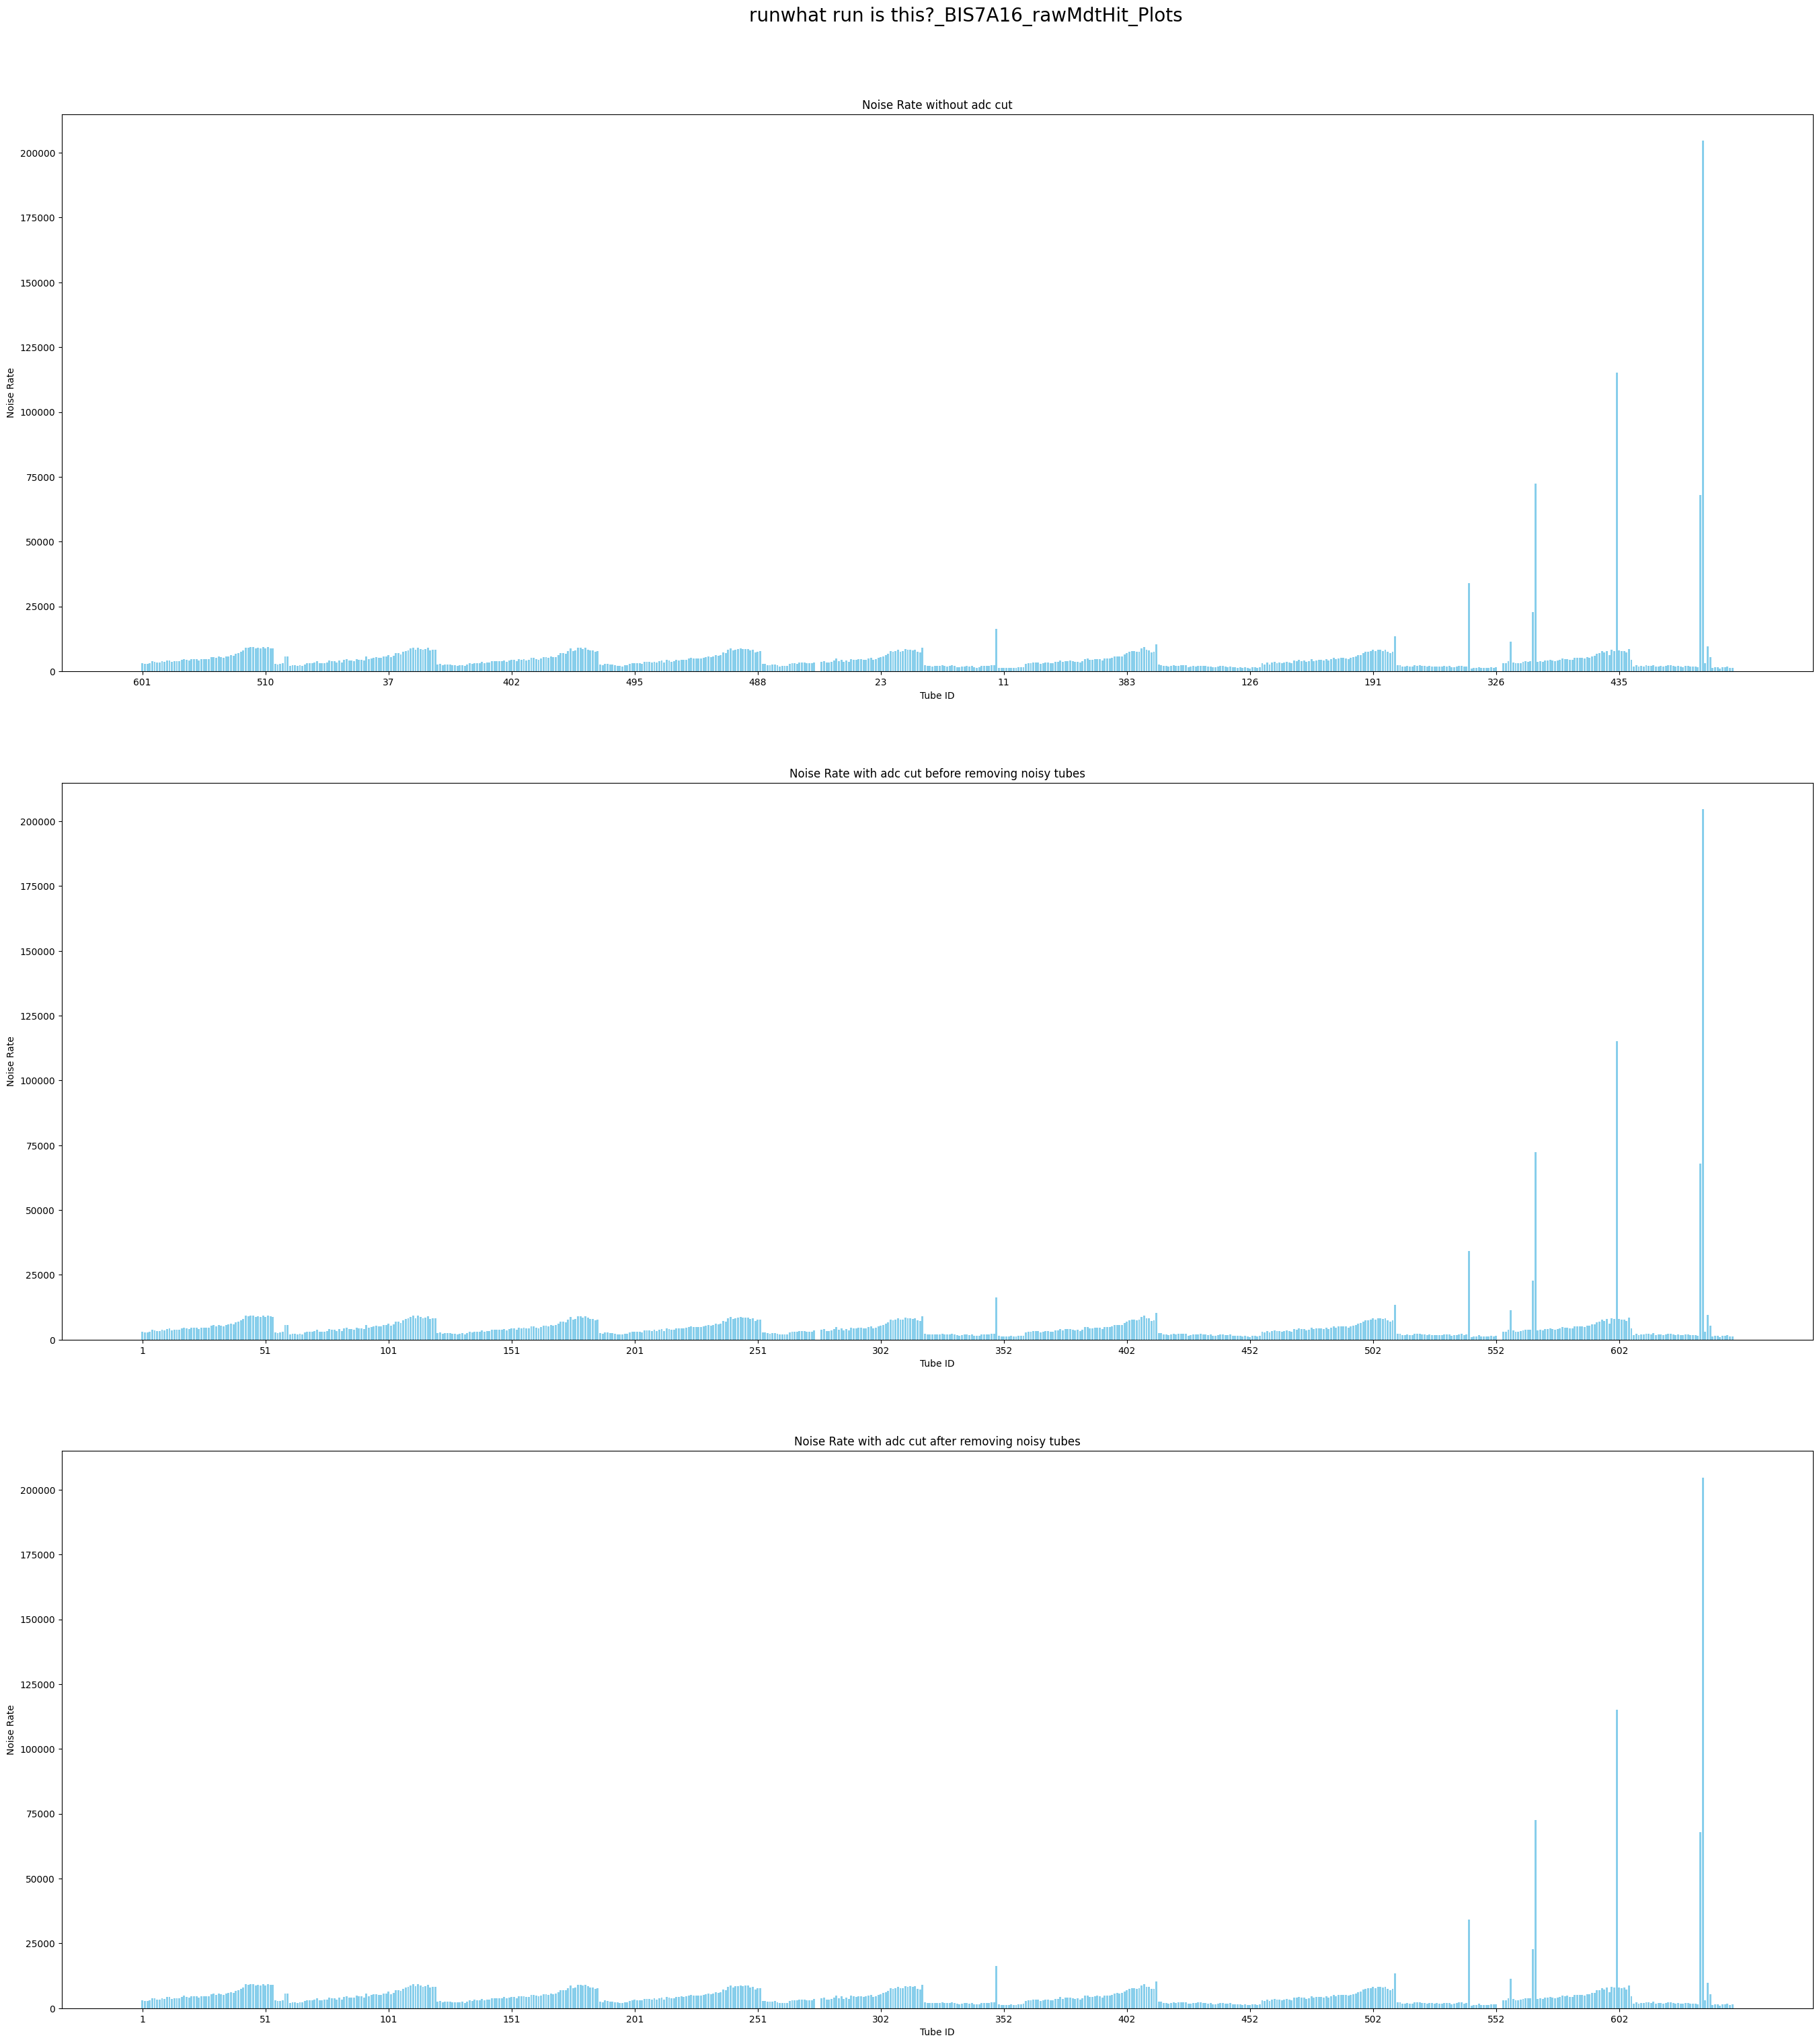

In [9]:
#Bar Plot
def plot_for_noise_rate(df, chamber):
    
    df_raw_chamber = df[df['rawMdt_station']==chamber]

    run='what run is this?'
    fig,axes = plt.subplots(figsize=(28, 32), nrows = 3, ncols = 1)
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.2, hspace = 0.2)
    fig.suptitle('run%s_%s_rawMdtHit_Plots'%(run,chamber), fontsize=20)
    alpha_value = 1  # Transparency
    
    df_noise_rate=noise_rate(df_raw_chamber,'BIS7A16')
    
    axes[0].bar(df_noise_rate['Tube_ID'].astype(str), df_noise_rate['Noise_Rate'], color='skyblue')
    axes[0].set_title('Noise Rate without adc cut')
    axes[0].set_xlabel('Tube ID')
    axes[0].set_ylabel('Noise Rate')
    axes[0].set_xticks(np.arange(0, len(df_noise_rate_with_adc_cut_sorted['Tube_ID'])+1, 50))
    
#Noise_rate Dataframe with adc_cut
    adc_cut=50
    df_raw_chamber_with_adc_cut=df_raw_chamber[df_raw_chamber['rawMdt_adc']>adc_cut]
    df_noise_rate_with_adc_cut = noise_rate(df_raw_chamber_with_adc_cut,'BIS7A16')
    df_noise_rate_with_adc_cut_sorted = df_noise_rate_with_adc_cut.sort_values(by='Tube_ID', ascending=True) 


    axes[1].bar(df_noise_rate_with_adc_cut_sorted['Tube_ID'].astype(str), df_noise_rate_with_adc_cut_sorted['Noise_Rate'], color='skyblue')
    axes[1].set_title('Noise Rate with adc cut before removing noisy tubes')
    axes[1].set_xlabel('Tube ID')
    axes[1].set_ylabel('Noise Rate')
    axes[1].set_xticks(np.arange(0, len(df_noise_rate_with_adc_cut_sorted['Tube_ID'])+1, 50))
    
#Noise_rate Dataframe with adc_cut and noisy tubes removed
    df_noise_rate_removed=
    axes[2].bar(df_noise_rate_with_adc_cut_sorted['Tube_ID'].astype(str), df_noise_rate_with_adc_cut_sorted['Noise_Rate'], color='skyblue')
    axes[2].set_title('Noise Rate with adc cut after removing noisy tubes')
    axes[2].set_xlabel('Tube ID')
    axes[2].set_ylabel('Noise Rate')
    axes[2].set_xticks(np.arange(0, len(df_noise_rate_with_adc_cut_sorted['Tube_ID'])+1, 50))

    plt.show()
plot_for_noise_rate(df_raw,'BIS7A16')

KeyError: 0      601
1      568
2      567
3      636
4      635
      ... 
642    452
643    276
644    275
645    553
646    554
Name: Tube_ID, Length: 647, dtype: int64

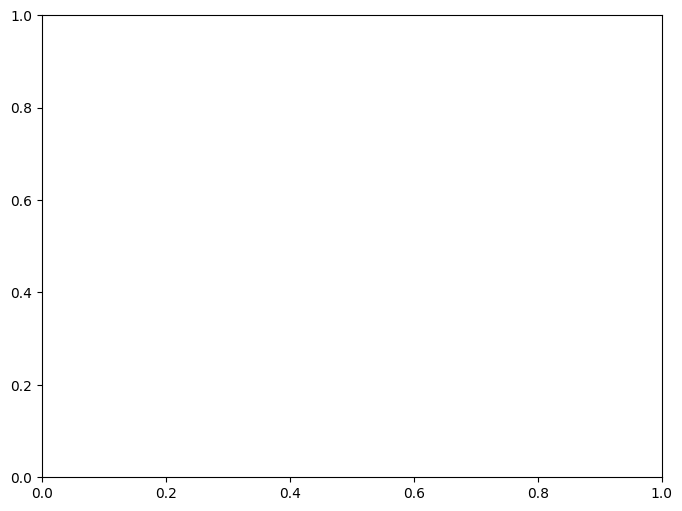

In [20]:
def noise_rate_plot(df):
    fig,ax=plt.subplots(figsize=(8,6))
    df_sorted=df.sort_values(by=df['Tube_ID'], axis=1, ascending=True)
    ax.bar(df_sorted['Tube_ID'].astype(str),df_sorted['Noise_Rate'])
    ax.set_title('Noise Rate vs Tube Id')
    ax.set_xticks(np.arange(0,len(df_sorted.Tube_ID)+1,50))
    plt.show()
noise_rate_plot(df_noise_rate)

# Introducing adc cut

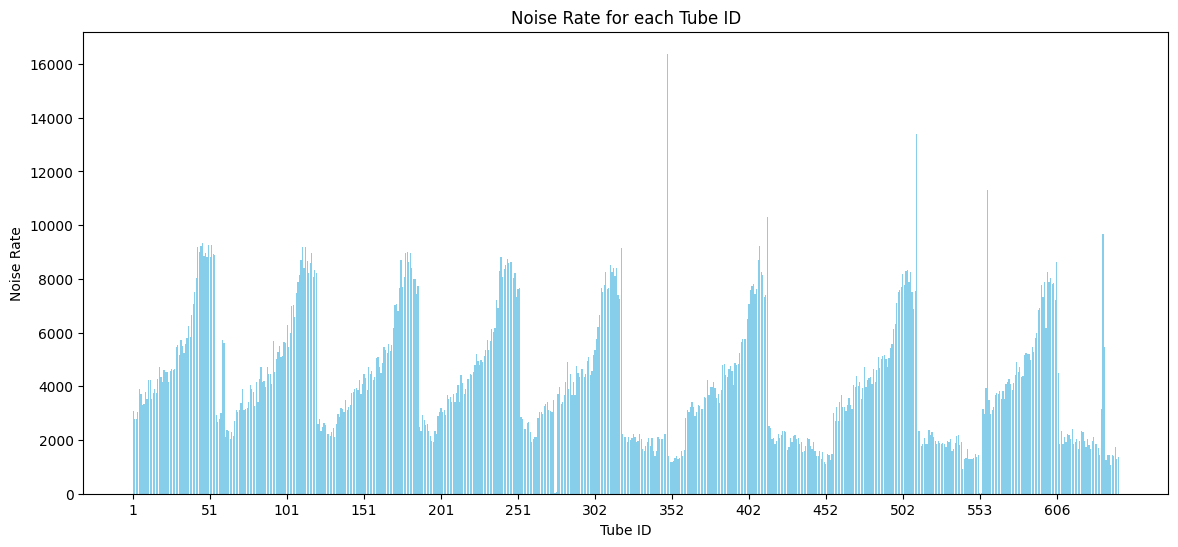

In [46]:
#extracting all tubes having noisy_rate more than 20k
extracted_df_aftr_removing_noisy_tubes=extracted_df[extracted_df['Noise_rate']<20000]
extracted_df_aftr_removing_noisy_tubes
plot_for_noise_rate(extracted_df_aftr_removing_noisy_tubes)

## Plot after adc cut

# Trials

# Hitmap plots

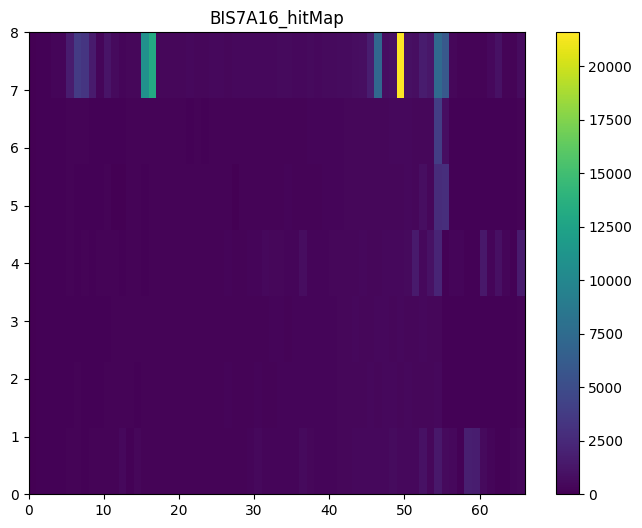

rawMdt_tubeInfo
BIS7A16-2-4-49    21178
BIS7A16-2-4-16    12837
BIS7A16-2-4-15    10598
BIS7A16-2-4-84    10243
BIS7A16-2-4-83     8686
                  ...  
BIS7A16-2-2-92       55
BIS7A16-2-1-12        8
BIS7A16-2-1-11        5
BIS7A16-2-4-1         4
BIS7A16-2-4-2         2
Name: count, Length: 647, dtype: int64


In [27]:
# plotting function for chamber hitMap and noise_hits  
def plotHitMap(df,chamber):
    df_raw_chamber = df[df['rawMdt_station']==chamber]
    
    chamberinfo = list(df_raw_chamber.rawMdt_tubeInfo)
    #apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo]
    ly =[int(x.split('-')[2]) for x in chamberinfo]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo]
    tb =[int(x.split('-')[3]) for x in chamberinfo]

    fig,ax = plt.subplots(figsize=(8,6))
    ax.set_title(f'{chamber}_hitMap')
    
    # get Maxtube per layer and total layer from chamberlist_run3.py
    maxLy = chamberlist_run3.MDTtotalLayers(chamber)
    maxTb = chamberlist_run3.MDTtotalTubes(chamber)
    
    counts, xedges, yedges, im = ax.hist2d(tb,nLayer, bins = [66,7], range= [[0,66],[0,8]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=ax)
    plt.show()
    # fig.savefig(f'run456729_{chamber}_hitMap_before_noise.png')

    #get hits from all tubes
    hit_info=df.rawMdt_tubeInfo.value_counts()
    # print(hit_info)
plotHitMap(df_raw_chamber,'BIS7A16')  #crude plot

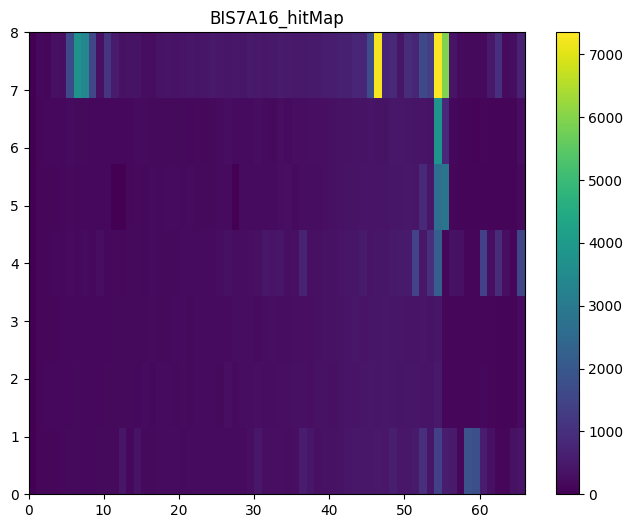

rawMdt_tubeInfo
BIS7A16-2-4-46    6839
BIS7A16-2-4-54    6833
BIS7A16-2-4-82    4588
BIS7A16-2-2-54    3810
BIS7A16-2-4-6     3591
                  ... 
BIS7A16-2-2-92      55
BIS7A16-2-1-12       8
BIS7A16-2-1-11       5
BIS7A16-2-4-1        4
BIS7A16-2-4-2        2
Name: count, Length: 641, dtype: int64


In [183]:
plotHitMap(df_raw_chamber_noisy_filtered,'BIS7A16')

In [4]:
# raw ADC and TDC hits plot with ADC cut at 50
def plotRawMdtHits(df_all,chamber):
    
    pd_mdt_chamber = df_all[df_all['rawMdt_station']==chamber]

    # make chamber overall info
    run = '456729'
    fig,axes = plt.subplots(figsize=(32, 18), nrows = 2, ncols = 3)
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.2, hspace = 0.2)
    fig.suptitle('run%s_%s_rawMdtHit_Plots'%(run,chamber), fontsize=20)
       
    # ADC count without cut
    mdt_adc = pd_mdt_chamber.rawMdt_adc.values.astype(float)
    min_adc = -50
    max_adc = 400
    xadc, xbins, patch = axes[0,0].hist(mdt_adc,bins=max_adc-min_adc,range=[min_adc,max_adc],label = 'adc')
    mean = np.average(mdt_adc)
    std = np.sqrt(np.average((mdt_adc - mean)**2))
    axes[0,0].set_xlim(min_adc,max_adc)
    axes[0,0].set_xlabel('adcCount',fontsize=15)
    axes[0,0].text(270,np.max(xadc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xadc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[0,0].grid()
    axes[0,0].set_title(f'{chamber}_rawADC')
    
    mdt_adc_cut = pd_mdt_chamber_cut.rawMdt_adc.values.astype(float)
    xadc, xbins, patch = axes[1,0].hist(mdt_adc_cut,bins=max_adc-min_adc,range=[min_adc,max_adc],label = 'adc')
    mean = np.average(mdt_adc_cut)
    std = np.sqrt(np.average((mdt_adc_cut - mean)**2))
    axes[1,0].set_xlim(min_adc,max_adc)
    axes[1,0].set_xlabel('adcCount',fontsize=15)
    axes[1,0].text(270,np.max(xadc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xadc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[1,0].grid()
    axes[1,0].set_title(f'{chamber}_rawADC_adcCut{adc_cut}')
    
    # raw TDC spectrum
    mdt_tdc = pd_mdt_chamber.rawMdt_tdc.values.astype(float)
    min_tdc = -50
    max_tdc = 1650
    xtdc, xbins, patch = axes[0,1].hist(mdt_tdc,bins= max_tdc-min_tdc,range=[min_tdc,max_tdc],label = 'tdc')
    axes[0,1].set_xlim(min_tdc,max_tdc)
    axes[0,1].set_xlabel('tdcCount',fontsize=15)
    axes[0,1].text(700,np.max(xtdc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xtdc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[0,1].grid()
    axes[0,1].set_title(f'{chamber}_rawTDC')
    
    chamberinfo = list(pd_mdt_chamber.rawMdt_tubeInfo)
    #apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo]
    ly =[int(x.split('-')[2]) for x in chamberinfo]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo]
    tb =[int(x.split('-')[3]) for x in chamberinfo]
    axes[0,2].set_title(f'{chamber}_hitMap')
    
    # get Maxtube per layer and total layer from chamberlist_run3.py
    maxLy = chamberlist_run3.MDTtotalLayers(chamber)
    maxTb = chamberlist_run3.MDTtotalTubes(chamber)
    
    counts, xedges, yedges, im = axes[0,2].hist2d(tb,nLayer, bins = [66,7], range= [[0,66],[1,8]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=axes[0,2])
    #mdtCalib_functions.fitResidual(x1,bins1,'Residual_unbias',ax)
    
    chamberinfo_cut = list(pd_mdt_chamber_cut.rawMdt_tubeInfo)
    #apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo_cut]
    ly =[int(x.split('-')[2]) for x in chamberinfo_cut]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo_cut]
    tb =[int(x.split('-')[3]) for x in chamberinfo_cut]
    axes[1,2].set_title(f'{chamber}_hitMap_adcCut')
    
    counts, xedges, yedges, im = axes[1,2].hist2d(tb,nLayer, bins = [66,7], range= [[0,66],[1,8]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=axes[1,2])
    
    fig.patch.set_facecolor('white')
    fig.savefig(f'run456729_{chamber}_rawMdtHit.png')
    plt.show()
    
plotRawMdtHits(df_raw,'BIS7A16')

27

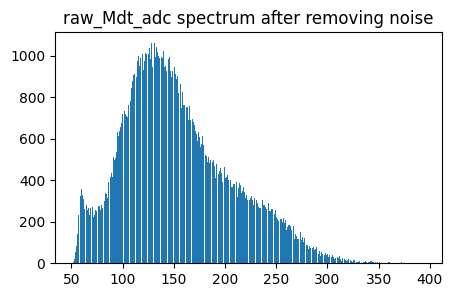

In [181]:
#raw_Mdt_adc spectrum before removing noise
def adc_spectrum(df):
    fig,ax=plt.subplots(figsize=(5,3))
    plt.hist(df.rawMdt_adc, bins=400)
    ax.set_title('raw_Mdt_adc spectrum after removing noise')
    # fig.savefig('raw_Mdt_adc_spectrum_BIS7A16_before_removing_noise')
    plt.show()
adc_cut = 50
df_raw_chamber_filtered_with_cut = df_raw_chamber_noisy_filtered[df_raw_chamber_noisy_filtered['rawMdt_adc']>adc_cut]
adc_spectrum(df_raw_chamber_filtered_with_cut)

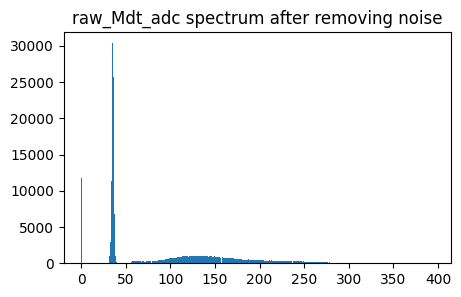

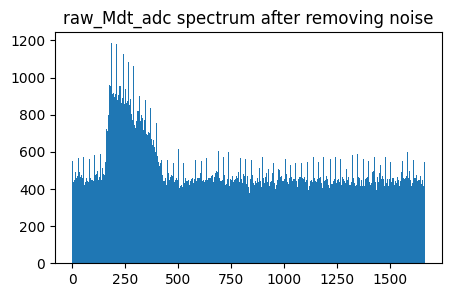

In [184]:
adc_spectrum(df_raw_chamber_noisy_filtered)
tdc_spectrum(df_raw_chamber_noisy_filtered)

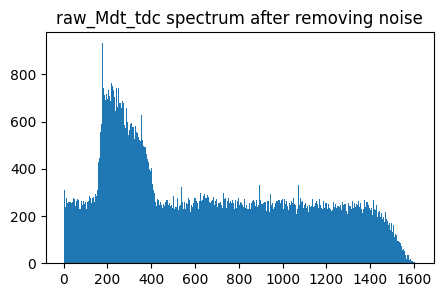

In [185]:
def tdc_spectrum(df):
    fig,ax=plt.subplots(figsize=(5,3))
    plt.hist(df.rawMdt_tdc, bins=400)
    ax.set_title('raw_Mdt_tdc spectrum after removing noise')
    # fig.savefig('raw_Mdt_adc_spectrum_BIS7A16_before_removing_noise')
    plt.show()
tdc_spectrum(df_raw_chamber_filtered_with_cut)

# Adc cut dataset

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

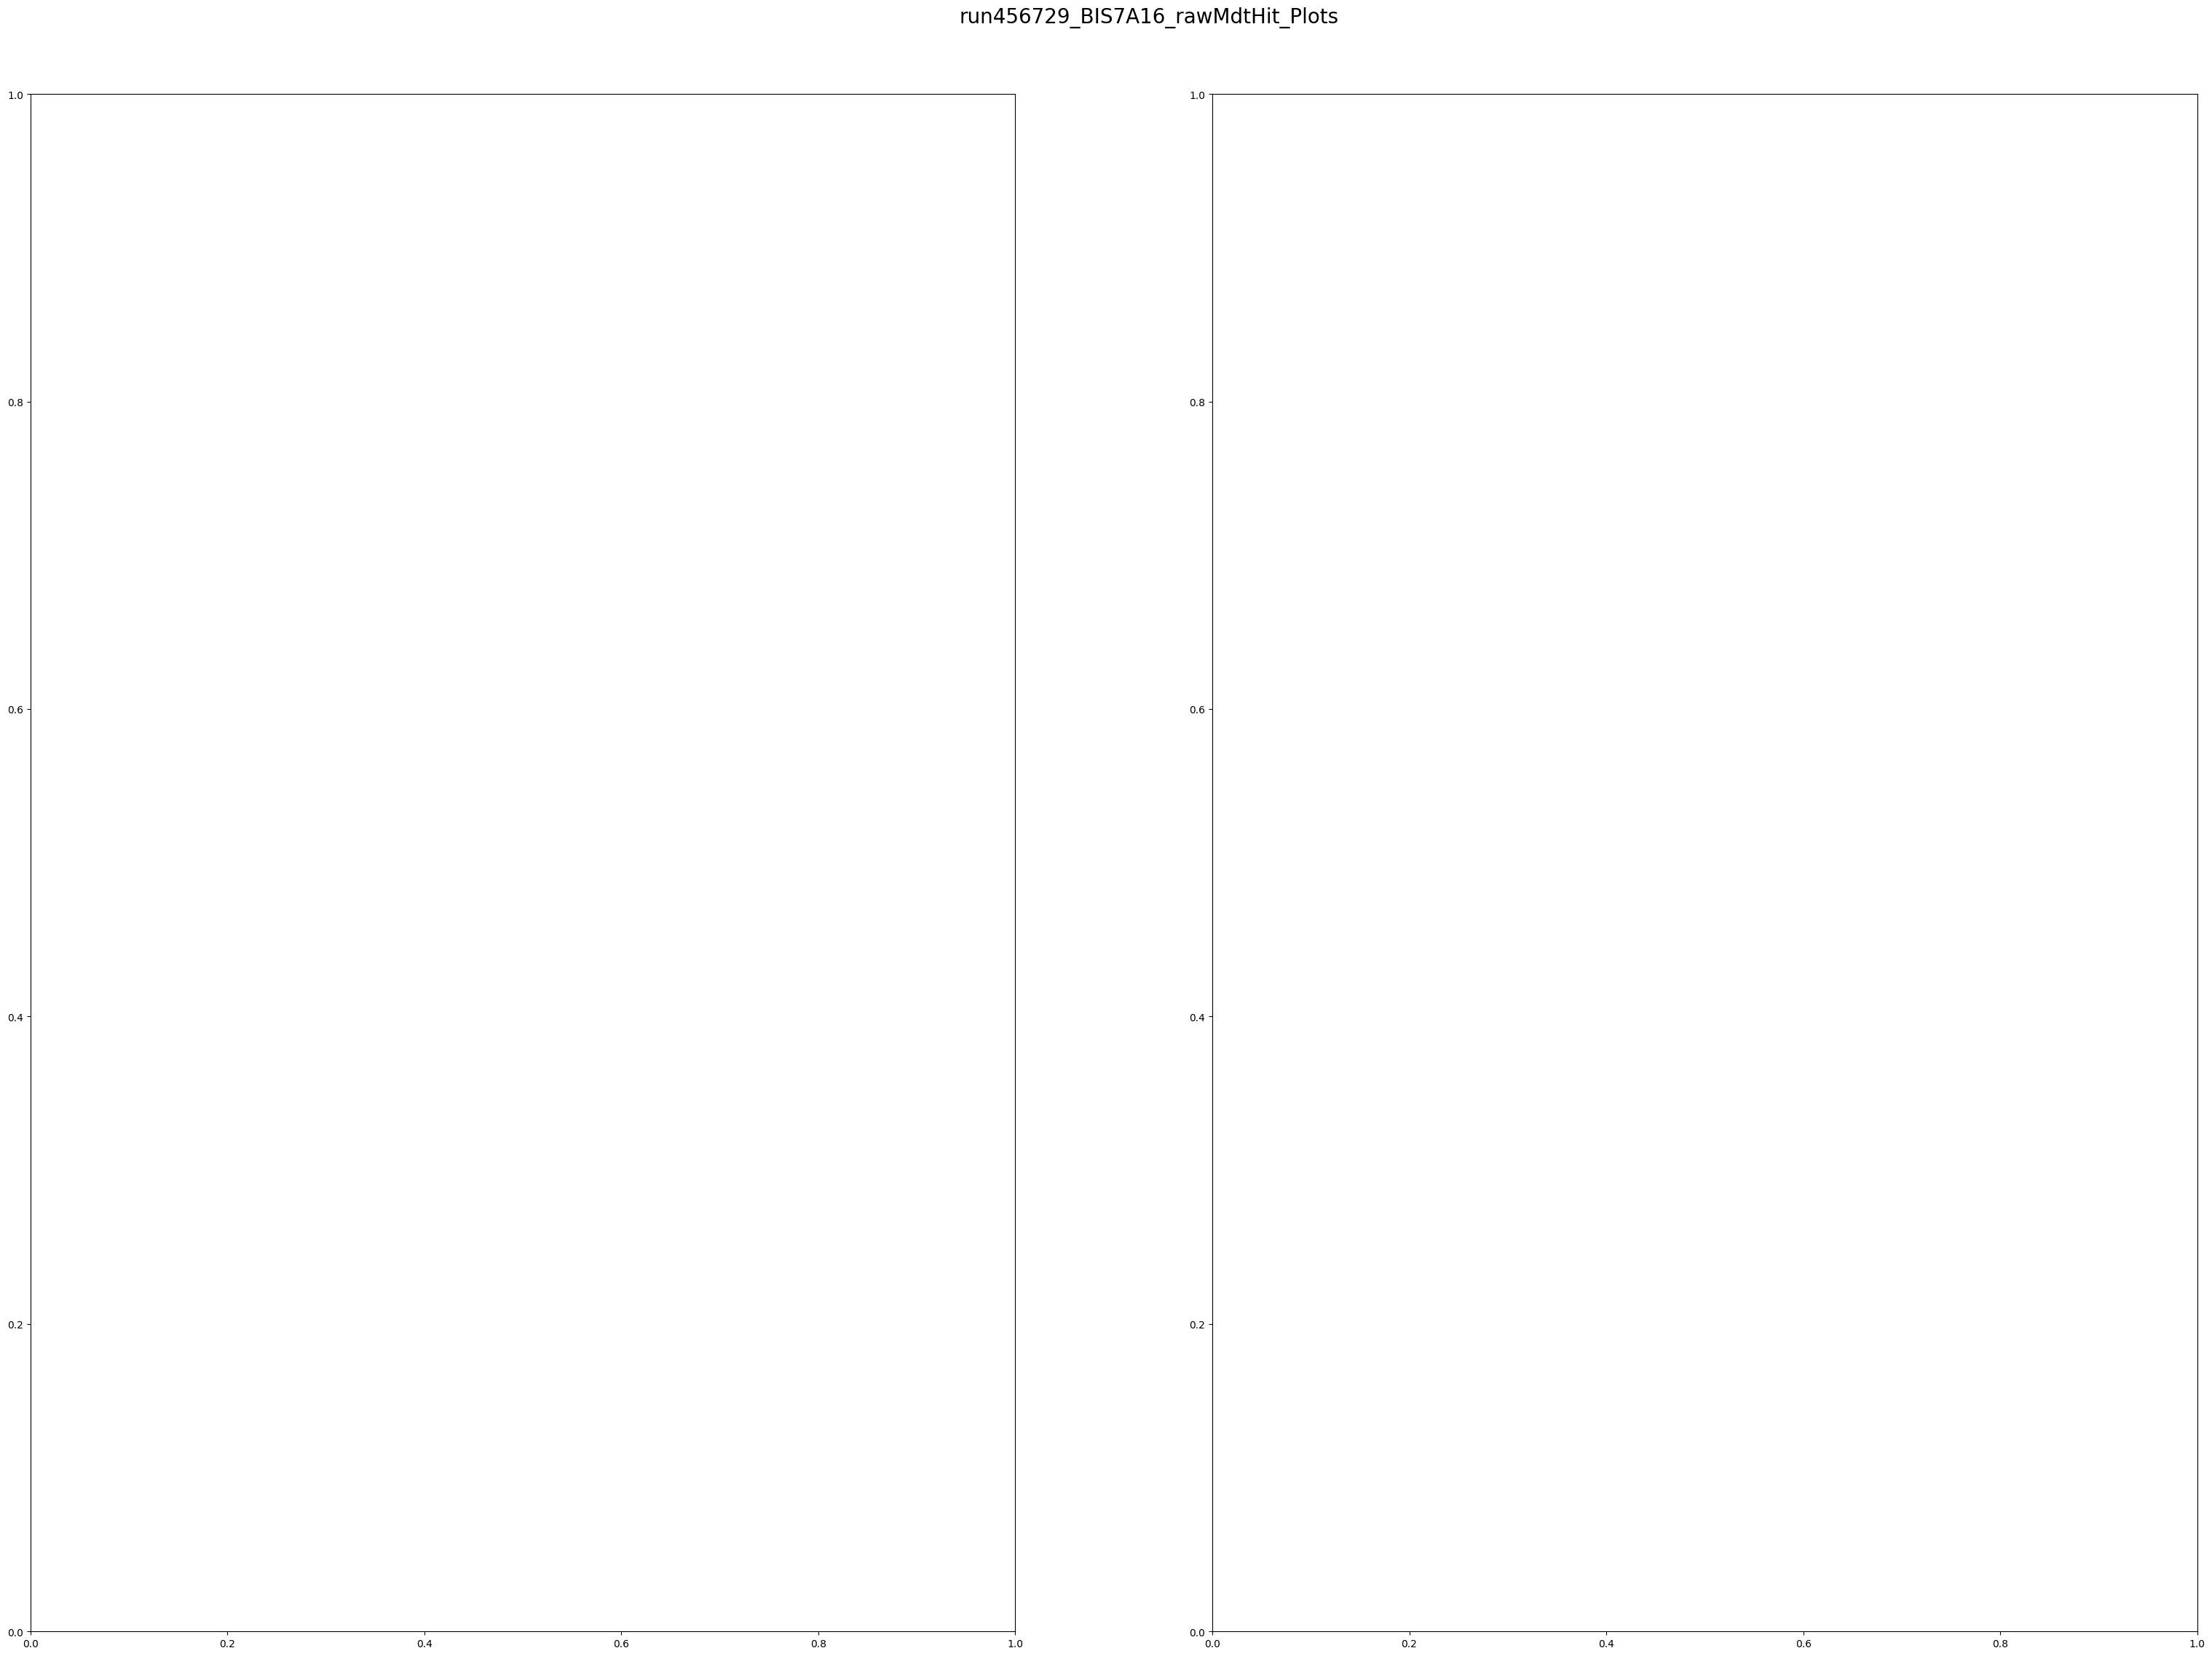

In [175]:
# raw ADC and TDC hits plot with and without ADC cut at 50
def plotRawMdtHits(chamber):
    
    # df_raw_chamber = df[df['rawMdt_station']==chamber]
    
    # make chamber overall info
    run = '456729'
    fig,axes = plt.subplots(figsize=(32, 24), nrows = 1, ncols = 2)
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.2, hspace = 0.2)
    fig.suptitle('run%s_%s_rawMdtHit_Plots'%(run,chamber), fontsize=20)

    #hitmap without adc
    # ADC count without cut
    mdt_adc = df_raw_chamber_noisy_filtered.rawMdt_adc.values.astype(float)
    min_adc = -50
    max_adc = 400
    
    xadc, xbins, patch = axes[0,0].hist(mdt_adc,bins=max_adc-min_adc,range=[min_adc,max_adc],label = 'adc')
    mean = np.average(mdt_adc)
    std = np.sqrt(np.average((mdt_adc - mean)**2))
    axes[0,0].set_xlim(min_adc,max_adc)
    axes[0,0].set_xlabel('adcCount',fontsize=15)
    axes[0,0].text(270,np.max(xadc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xadc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[0,0].grid()
    axes[0,0].set_title(f'{chamber}_rawADC')
    
    # mdt_adc_cut = df_raw_chamber_with_cut.rawMdt_adc.values.astype(float)
    
    # xadc, xbins, patch = axes[1,0].hist(mdt_adc_cut,bins=max_adc-min_adc,range=[min_adc,max_adc],label = 'adc')
    # mean = np.average(mdt_adc_cut)
    # std = np.sqrt(np.average((mdt_adc_cut - mean)**2))
    # axes[1,0].set_xlim(min_adc,max_adc)
    # axes[1,0].set_xlabel('adcCount',fontsize=15)
    # axes[1,0].text(270,np.max(xadc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xadc),mean,std),backgroundcolor='linen',fontsize =13)
    # axes[1,0].grid()
    # axes[1,0].set_title(f'{chamber}_rawADC_adcCut{adc_cut}')

    
    # raw TDC spectrum
    mdt_tdc = df_raw_chamber_noisy_filtered.rawMdt_tdc.values.astype(float)
    min_tdc = -50
    max_tdc = 1650
    xtdc, xbins, patch = axes[0,1].hist(mdt_tdc,bins= max_tdc-min_tdc,range=[min_tdc,max_tdc],label = 'tdc')
    axes[0,1].set_xlim(min_tdc,max_tdc)
    axes[0,1].set_xlabel('tdcCount',fontsize=15)
    axes[0,1].text(700,np.max(xtdc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xtdc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[0,1].grid()
    axes[0,1].set_title(f'{chamber}_rawTDC')

    
    # mdt_tdc_cut = df_raw_chamber_with_cut.rawMdt_tdc.values.astype(float)
    # xtdc, xbins, patch = axes[1,1].hist(mdt_tdc_cut,bins= max_tdc-min_tdc,range=[min_tdc,max_tdc],label = 'tdc')
    # axes[1,1].set_xlim(min_tdc,max_tdc)
    # axes[1,1].set_xlabel('tdcCount',fontsize=15)
    # axes[1,1].text(700,np.max(xtdc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xtdc),mean,std),backgroundcolor='linen',fontsize =13)
    # axes[1,1].grid()
    # axes[1,1].set_title(f'{chamber}_rawTDC_adcCut{adc_cut}')

    
   #  mdt_tdc_cut_filtered = df_raw_chamber_filtered.rawMdt_tdc.values.astype(float)
   #  xtdc, xbins, patch = axes[1,1].hist(mdt_tdc_cut_filtered,bins= max_tdc-min_tdc,range=[min_tdc,max_tdc],label = 'tdc')
   #  axes[2,1].set_xlim(min_tdc,max_tdc)
   #  axes[2,1].set_xlabel('tdcCount',fontsize=15)
   #  axes[2,1].text(700,np.max(xtdc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xtdc),mean,std),backgroundcolor='linen',fontsize =13)
   #  axes[2,1].grid()
   #  axes[2,1].set_title(f'{chamber}_rawTDC_adcCut{adc_cut}')
   # #  # fit t0
   # #  # driftTime spectrum
   #  #t0_fit,tmax_fit, axes[0,2] = mdtCalib_functions.fitT0Tmax(mdt_tdc_cut,chamber,axes[0,2])
    
   #Hitmap after removing noise 
    # Chamberinfo = list(df_raw_chamber_noisy_filtered.rawMdt_tubeInfo)
    # #apply to ML-Layer-Tube columns
    # ml =[int(x.split('-')[1]) for x in Chamberinfo]
    # ly =[int(x.split('-')[2]) for x in Chamberinfo]
    # nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in Chamberinfo]
    # ntb =[int(x.split('-')[3]) for x in Chamberinfo]
    # axes[0,1].set_title(f'{chamber}_hitMap_filtered')
    
    # # get Maxtube per layer and total layer from chamberlist_run3.py
    # maxLy = chamberlist_run3.MDTtotalLayers(chamber)
    # maxTb = chamberlist_run3.MDTtotalTubes(chamber)
    
    # counts, xedges, yedges, im = axes[0,2].hist2d(ntb,nLayer, bins = [66,7], range= [[0,66],[0,8]], cmap=plt.cm.viridis,label='hitMap')
    # fig.colorbar(im, ax=axes[0,2])
    #mdtCalib_functions.fitResidual(x1,bins1,'Residual_unbias',ax)
    
    # chamberinfo_cut = list(df_raw_chamber_with_cut.rawMdt_tubeInfo)
    # # apply to ML-Layer-Tube columns
    # ml =[int(x.split('-')[1]) for x in chamberinfo_cut]
    # ly =[int(x.split('-')[2]) for x in chamberinfo_cut]
    # nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo_cut]
    # ntb =[int(x.split('-')[3]) for x in chamberinfo_cut]
    # axes[2,2].set_title(f'{chamber}_hitMap_adcCut_filtered')
    
    # counts, xedges, yedges, im = axes[2,2].hist2d(ntb,nLayer, bins = [66,7], range= [[0,66],[0,8]], cmap=plt.cm.viridis,label='hitMap')
    # fig.colorbar(im, ax=axes[2,2])

    # chamberinfo_cut = list(df_raw_chamber_filtered.rawMdt_tubeInfo)
    # # apply to ML-Layer-Tube columns
    # ml =[int(x.split('-')[1]) for x in chamberinfo_cut]
    # ly =[int(x.split('-')[2]) for x in chamberinfo_cut]
    # nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo_cut]
    # ntb =[int(x.split('-')[3]) for x in chamberinfo_cut]
    # axes[2,2].set_title(f'{chamber}_hitMap_adcCut_filtered')
    
    # counts, xedges, yedges, im = axes[2,2].hist2d(ntb,nLayer, bins = [66,7], range= [[0,66],[0,8]], cmap=plt.cm.viridis,label='hitMap')
    # fig.colorbar(im, ax=axes[2,2])
    
    fig.patch.set_facecolor('white')
    # fig.savefig(f'run456729_{chamber}_rawMdtHit.png')
    plt.show()
    
plotRawMdtHits('BIS7A16')


In [16]:
#plot after removing noise
def plotHitMap_after_noise(chamber):
    
    # df_raw_chamber = df_raw[df_raw['rawMdt_station']==chamber]

    chamberinfo = list(df_raw_chamber.rawMdt_tubeInfo)
    #apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo]
    ly =[int(x.split('-')[2]) for x in chamberinfo]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo]
    tb =[int(x.split('-')[3]) for x in chamberinfo]

    fig,ax = plt.subplots(figsize=(8,6))
    ax.set_title(f'{chamber}_hitMap_after_noise')
    
    # get Maxtube per layer and total layer from chamberlist_run3.py
    maxLy = chamberlist_run3.MDTtotalLayers(chamber)
    maxTb = chamberlist_run3.MDTtotalTubes(chamber)
    
    counts, xedges, yedges, im = ax.hist2d(tb,nLayer, bins = [66,7], range= [[0,66],[1,8]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=ax)
    plt.show()
    fig.savefig(f'run456729_{chamber}_hitMap_after_noise.png')

    # #get hits from all tubes
    # hit_info=df_raw_chamber.rawMdt_tubeInfo.value_counts()
    # print(hit_info)
plotHitMap('BIS7A16')

NameError: name 'BIS7A16' is not defined

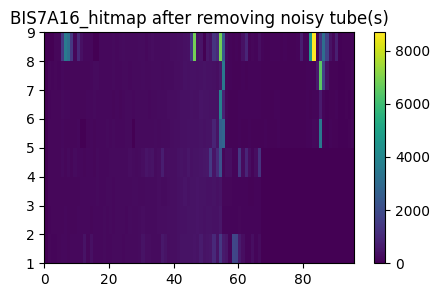

In [186]:
#plot after removing noise

# df_raw_chamber_nr = df_raw_chamber[(df_raw_chamber['rawMdt_tubeInfo'] != 'BIS7A16-2-4-49') & (df_raw_chamber['rawMdt_tubeInfo'] != 'BIS7A16-2-4-16')
# & (df_raw_chamber['rawMdt_tubeInfo'] != 'BIS7A16-2-4-15') & (df_raw_chamber['rawMdt_tubeInfo'] != 'BIS7A16-2-4-84') ]
# df_raw_chamber_nr

df_raw_chamber_nr=df_raw_chamber[df_raw_chamber[x] for x in noisy_tubes]

chamberinfo = list(df_raw_chamber_nr.rawMdt_tubeInfo)
# chamberinfo=list(df_trk_chamber.trkHit_tubeInfo)
# chamberinfo   #extracted all chamber name as a list
#apply to ML-Layer-Tube columns
ml =[int(x.split('-')[1]) for x in chamberinfo]
# ml   #BIS7A16-2-4-83
ly =[int(x.split('-')[2]) for x in chamberinfo]
nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo]  #no of layers maybe?
tb =[int(x.split('-')[3]) for x in chamberinfo]
tb    #tube number
# get Maxtube per layer and total layer from chamberlist_run3.py
maxLy = chamberlist_run3.MDTtotalLayers('BIS7A16')
maxTb = chamberlist_run3.MDTtotalTubes('BIS7A16')
# maxLy, maxTb

#plot
fig,ax=plt.subplots(figsize=(5,3))
ax.set_title('BIS7A16_hitmap after removing noisy tube(s)')
count_r, xedges, yedges, im = ax.hist2d(tb,nLayer, bins = [96,8], range= [[0,96],[1,9]], cmap=plt.cm.viridis,label='hitMap')  #tb, nLayers why use?
fig.colorbar(im, ax=ax)
# fig.savefig('BIS7A16_hitMap_after_noise.png')
plt.show()

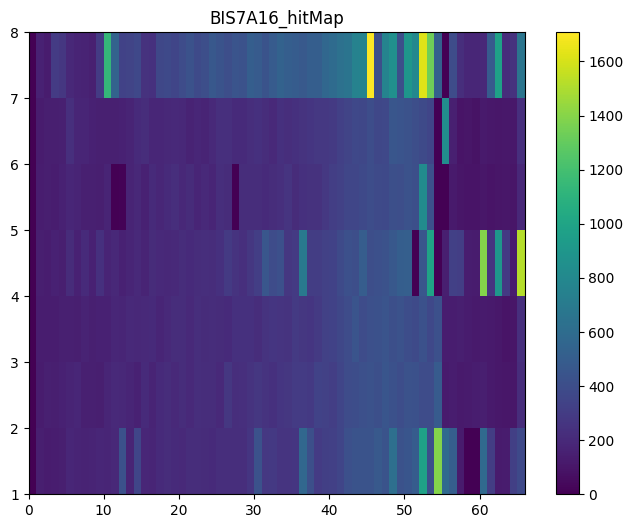

In [17]:
# plotting function for channel hitMap before removing the noisy tube
def plotHitMap(df, chamber):
    
    # pd_mdt_chamber = df_all[df_all['rawMdt_station']==chamber]

    chamberinfo = list(df.rawMdt_tubeInfo)
    #apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo]
    ly =[int(x.split('-')[2]) for x in chamberinfo]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo]
    tb =[int(x.split('-')[3]) for x in chamberinfo]

    fig,ax = plt.subplots(figsize=(8,6))
    ax.set_title(f'{chamber}_hitMap')
    
    # get Maxtube per layer and total layer from chamberlist_run3.py
    maxLy = chamberlist_run3.MDTtotalLayers(chamber)
    maxTb = chamberlist_run3.MDTtotalTubes(chamber)
    
    counts, xedges, yedges, im = ax.hist2d(tb,nLayer, bins = [66,7], range= [[0,66],[1,8]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=ax)
    plt.show()
    fig.savefig(f'run456729_{chamber}_hitMap_after_removing_noise.png')
    # return counts
    
plotHitMap(df_raw_chamber, 'BIS7A16')


In [89]:
df_raw_chamber['value_counts']=df_raw_chamber.apply(df_raw_chamber[df_raw_chamber['rawMdt_tubeInfo'].value_counts()])
df_raw_chamber

KeyError: "None of [Index([1760, 1707, 1701, 1445, 1416, 1409, 1394, 1388, 1351, 1333,\n       ...\n         60,   60,   60,   58,   57,   55,    8,    5,    4,    2],\n      dtype='int64', length=626)] are in the [columns]"

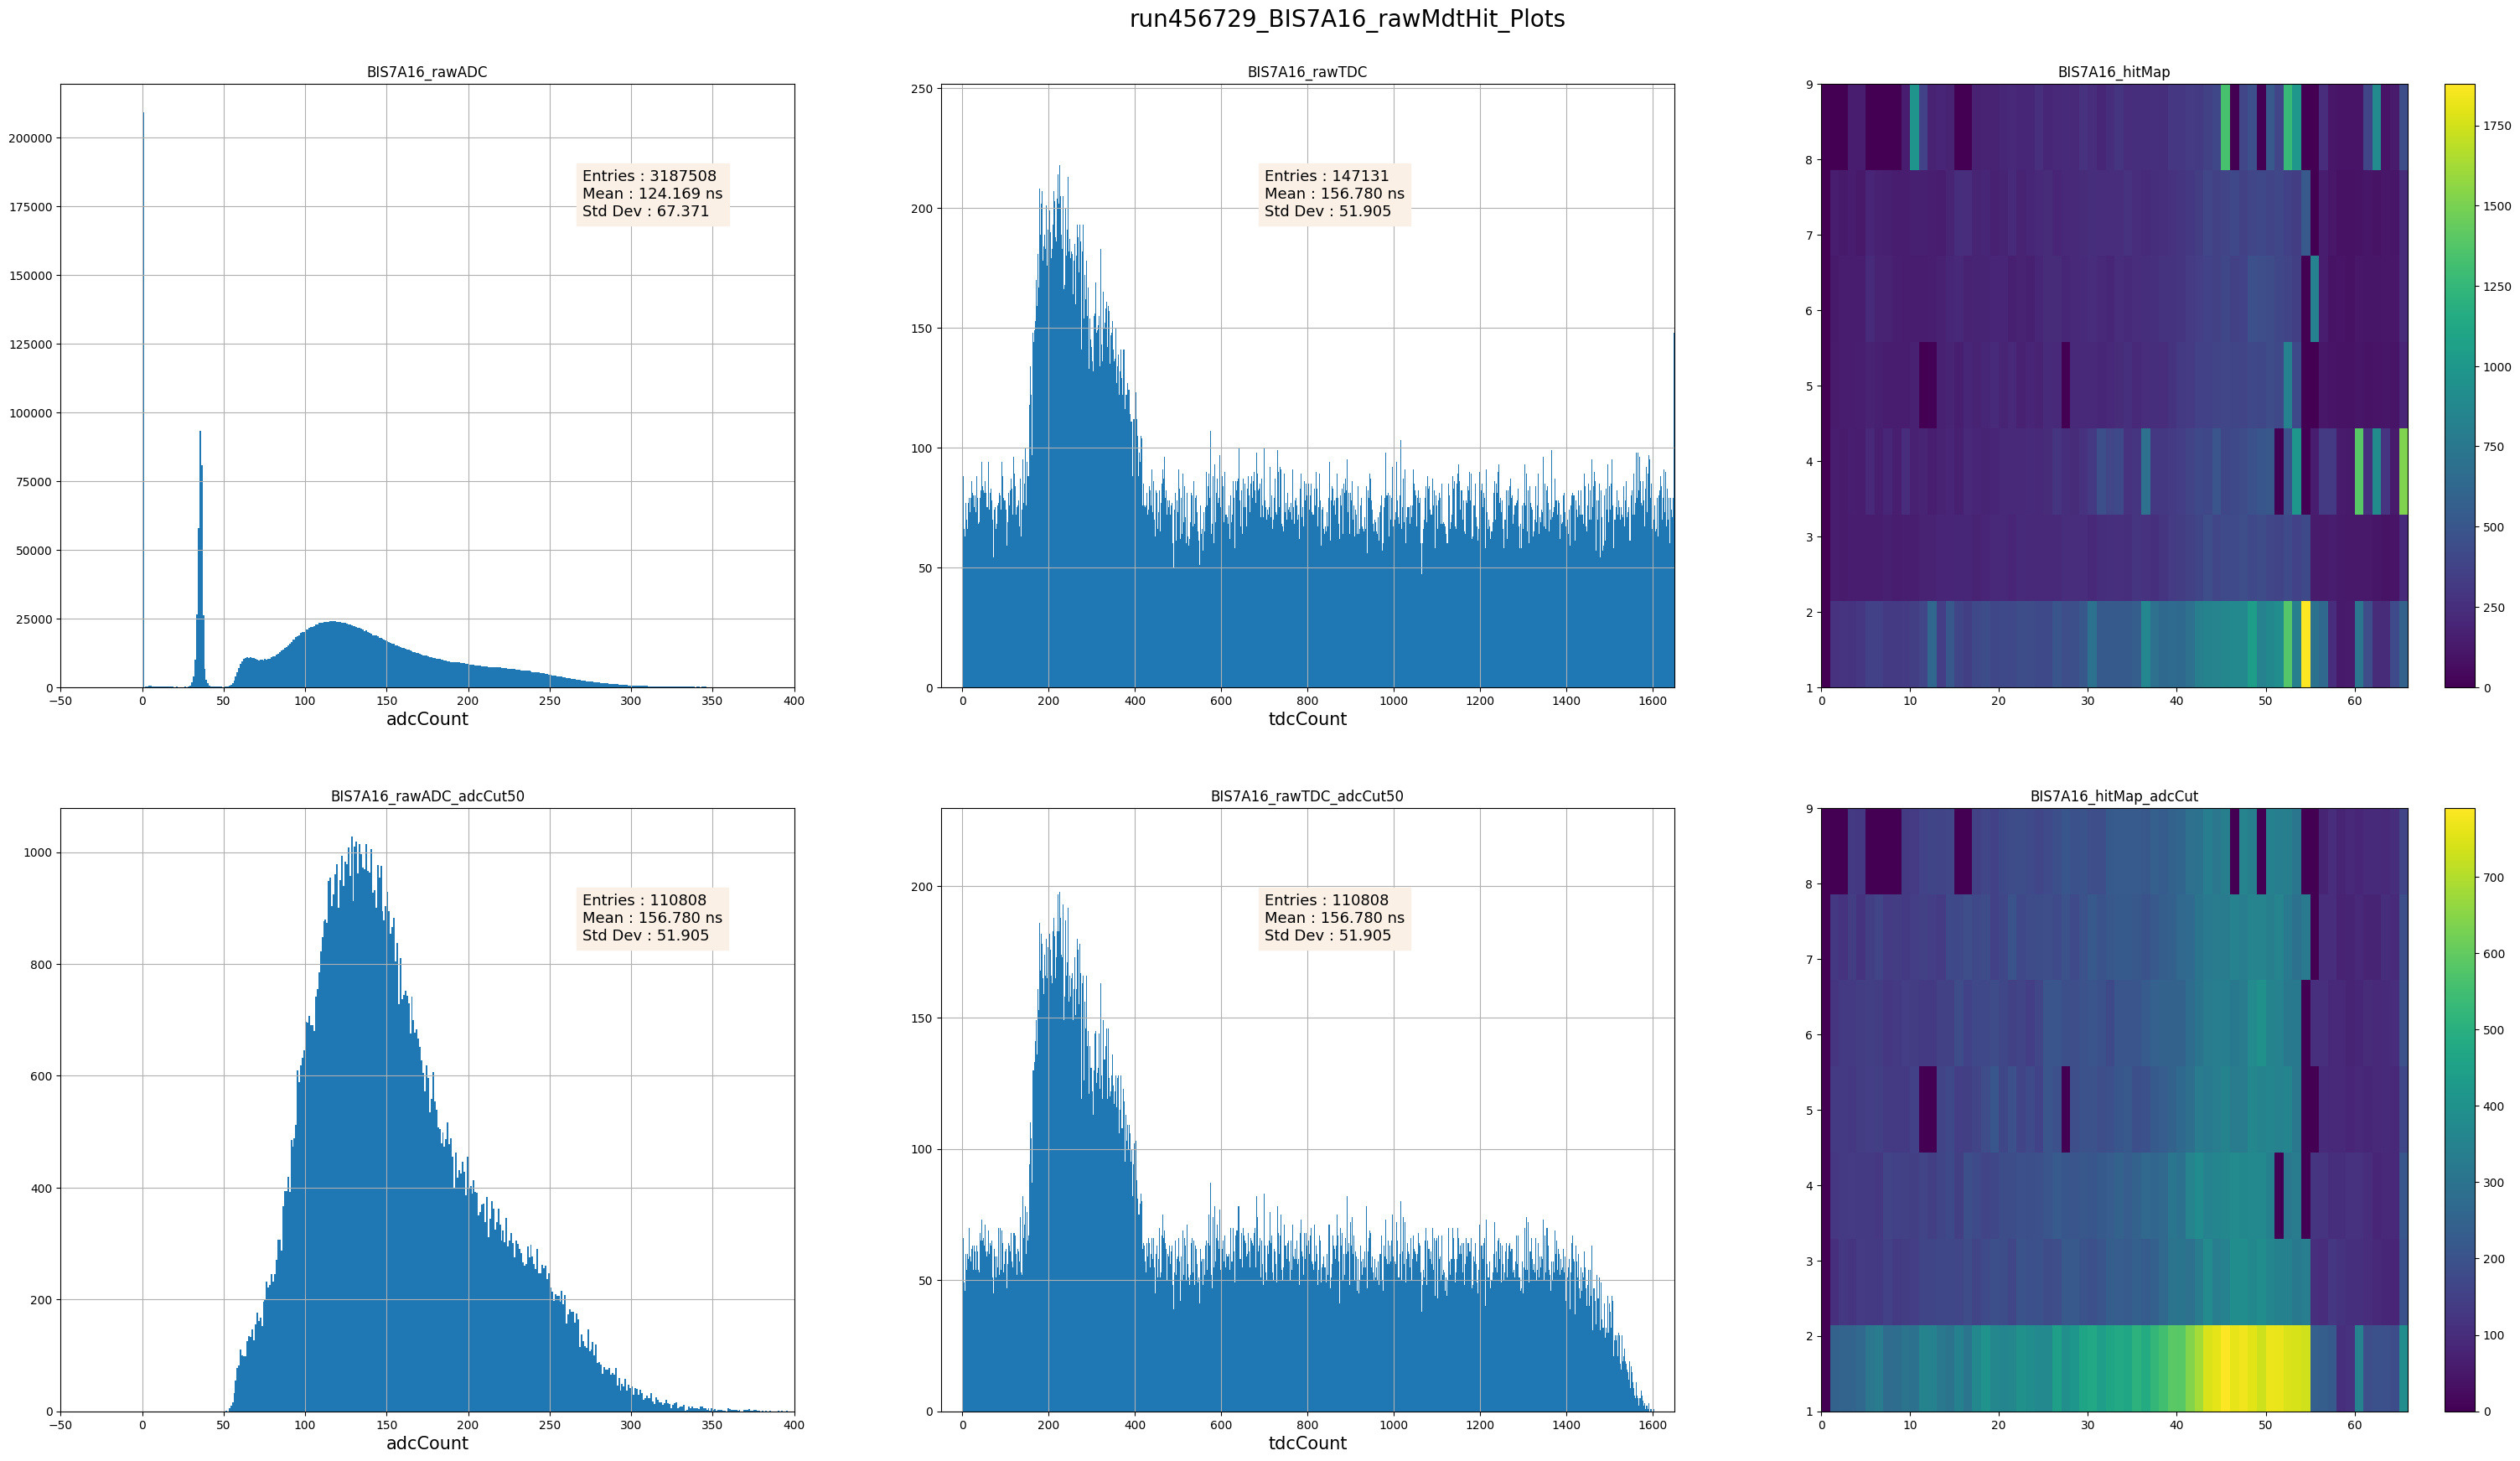

In [13]:
# raw ADC and TDC hits plot with and without ADC cut at 50
def plotRawMdtHits(df_raw_chamber,chamber):

    # pd_mdt_chamber = df_all[df_all['rawMdt_station']==chamber]
    adc_cut = 50
    df_raw_chamber_with_cut = df_raw_chamber[df_raw_chamber['rawMdt_adc']>adc_cut]
    
    # make chamber overall info
    run = '456729'
    fig,axes = plt.subplots(figsize=(32, 18), nrows = 3, ncols = 3)
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.2, hspace = 0.2)
    fig.suptitle('run%s_%s_rawMdtHit_Plots'%(run,chamber), fontsize=20)
       
    # ADC count without cut
    mdt_adc = df_raw.rawMdt_adc.values.astype(float)
    min_adc = -50
    max_adc = 400
    xadc, xbins, patch = axes[0,0].hist(mdt_adc,bins=max_adc-min_adc,range=[min_adc,max_adc],label = 'adc')
    mean = np.average(mdt_adc)
    std = np.sqrt(np.average((mdt_adc - mean)**2))
    axes[0,0].set_xlim(min_adc,max_adc)
    axes[0,0].set_xlabel('adcCount',fontsize=15)
    axes[0,0].text(270,np.max(xadc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xadc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[0,0].grid()
    axes[0,0].set_title(f'{chamber}_rawADC')
    
    mdt_adc_cut = df_raw_chamber_with_cut.rawMdt_adc.values.astype(float)
    xadc, xbins, patch = axes[1,0].hist(mdt_adc_cut,bins=max_adc-min_adc,range=[min_adc,max_adc],label = 'adc')
    mean = np.average(mdt_adc_cut)
    std = np.sqrt(np.average((mdt_adc_cut - mean)**2))
    axes[1,0].set_xlim(min_adc,max_adc)
    axes[1,0].set_xlabel('adcCount',fontsize=15)
    axes[1,0].text(270,np.max(xadc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xadc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[1,0].grid()
    axes[1,0].set_title(f'{chamber}_rawADC_adcCut{adc_cut}')

    
    # raw TDC spectrum
    mdt_tdc = df_raw_chamber.rawMdt_tdc.values.astype(float)
    min_tdc = -50
    max_tdc = 1650
    xtdc, xbins, patch = axes[0,1].hist(mdt_tdc,bins= max_tdc-min_tdc,range=[min_tdc,max_tdc],label = 'tdc')
    axes[0,1].set_xlim(min_tdc,max_tdc)
    axes[0,1].set_xlabel('tdcCount',fontsize=15)
    axes[0,1].text(700,np.max(xtdc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xtdc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[0,1].grid()
    axes[0,1].set_title(f'{chamber}_rawTDC')

    
    mdt_tdc_cut = df_raw_chamber_with_cut.rawMdt_tdc.values.astype(float)
    xtdc, xbins, patch = axes[1,1].hist(mdt_tdc_cut,bins= max_tdc-min_tdc,range=[min_tdc,max_tdc],label = 'tdc')
    axes[1,1].set_xlim(min_tdc,max_tdc)
    axes[1,1].set_xlabel('tdcCount',fontsize=15)
    axes[1,1].text(700,np.max(xtdc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xtdc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[1,1].grid()
    axes[1,1].set_title(f'{chamber}_rawTDC_adcCut{adc_cut}')
    
    # fit t0
    # driftTime spectrum
    #t0_fit,tmax_fit, axes[0,2] = mdtCalib_functions.fitT0Tmax(mdt_tdc_cut,chamber,axes[0,2])
    
    
    chamberinfo = list(df_raw_chamber.rawMdt_tubeInfo)
    #apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo]
    ly =[int(x.split('-')[2]) for x in chamberinfo]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo]
    tb =[int(x.split('-')[3]) for x in chamberinfo]
    axes[0,2].set_title(f'{chamber}_hitMap')
    
    # get Maxtube per layer and total layer from chamberlist_run3.py
    maxLy = chamberlist_run3.MDTtotalLayers(chamber)
    maxTb = chamberlist_run3.MDTtotalTubes(chamber)
    
    counts, xedges, yedges, im = axes[0,2].hist2d(tb,nLayer, bins = [66,7], range= [[0,66],[1,9]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=axes[0,2])
    #mdtCalib_functions.fitResidual(x1,bins1,'Residual_unbias',ax)
    
    chamberinfo_cut = list(df_raw_chamber_with_cut.rawMdt_tubeInfo)
    #apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo_cut]
    ly =[int(x.split('-')[2]) for x in chamberinfo_cut]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo_cut]
    tb =[int(x.split('-')[3]) for x in chamberinfo_cut]
    axes[1,2].set_title(f'{chamber}_hitMap_adcCut')
    
    counts, xedges, yedges, im = axes[1,2].hist2d(tb,nLayer, bins = [66,7], range= [[0,66],[1,9]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=axes[1,2])
    
    fig.patch.set_facecolor('white')
    fig.savefig(f'run456729_{chamber}_rawMdtHit.png')
    plt.show()
    
plotRawMdtHits(df_raw_chamber,'BIS7A16')

In [167]:
# #before removing noise
# df=pd.DataFrame(count)
# df.columns=['ML1l1','ML1l2','ML1l3','ML1l4','ML2l1','ML2l2','ML2l3','ML2l4']
# df

#after removing noise
df_r=pd.DataFrame(count_r)
df_r.columns=['ML1l1','ML1l2','ML1l3','ML1l4','ML2l1','ML2l2','ML2l3','ML2l4']
df_r

max_hitpoint=df_r.max()
print(max_hitpoint)
max_hitpoint_index=df_r.idxmax()
print(max_hitpoint_index)

ML1l1    1848.0
ML1l2     486.0
ML1l3     443.0
ML1l4    2159.0
ML2l1    3508.0
ML2l2    3810.0
ML2l3    6490.0
ML2l4    8686.0
dtype: float64
ML1l1    58
ML1l2    54
ML1l3    47
ML1l4    54
ML2l1    85
ML2l2    54
ML2l3    85
ML2l4    83
dtype: int64


In [154]:
max_hitpoint=df.max()
print(max_hitpoint)
max_hitpoint_index=df.idxmax()
print(max_hitpoint_index)

# tb5, 54 row

ML1l1     1848.0
ML1l2      486.0
ML1l3      443.0
ML1l4     2159.0
ML2l1     3508.0
ML2l2     3810.0
ML2l3     6490.0
ML2l4    21178.0
dtype: float64
ML1l1    58
ML1l2    54
ML1l3    47
ML1l4    54
ML2l1    85
ML2l2    54
ML2l3    85
ML2l4    49
dtype: int64


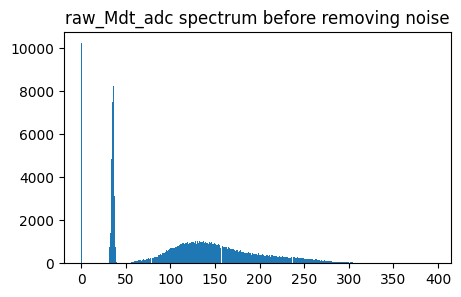

In [18]:
#raw_Mdt_adc spectrum before removing noise
fig,ax=plt.subplots(figsize=(5,3))
plt.hist(df_raw_chamber.rawMdt_adc, bins=400)
ax.set_title('raw_Mdt_adc spectrum before removing noise')
fig.savefig('raw_Mdt_adc_spectrum_BIS7A16_before_removing_noise')
plt.show()

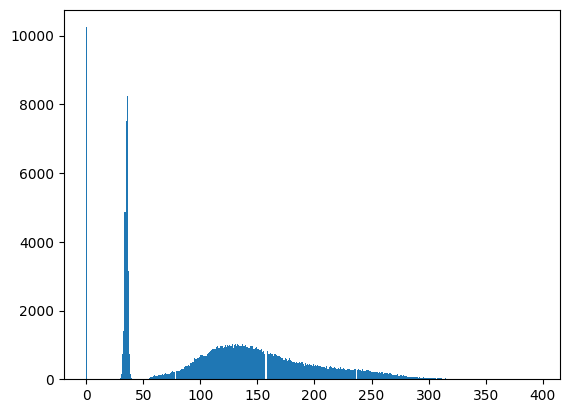

In [20]:
#raw_Mdt_adc spectrum after removing noise
plt.hist(df_raw_chamber.rawMdt_adc, bins=400)
ax.set_title('raw_Mdt_adc spectrum after removing noise')
fig.savefig('raw_Mdt_adc_spectrum_BIS7A16_after_removing_noise')
plt.show()

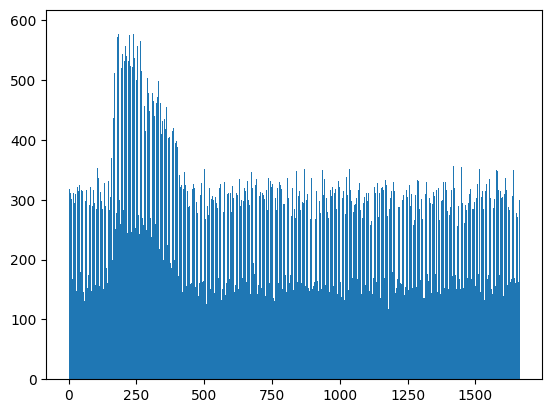

In [183]:
# rawMdt tdc spectrum  removing noise
plt.hist(df_raw_chamber.rawMdt_tdc, bins=1000)
plt.show()

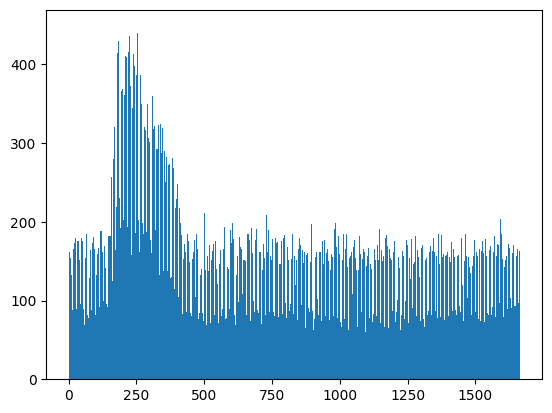

In [93]:
#rawMdt tdc spectrum after removing noise
plt.hist(df_raw_chamber.rawMdt_tdc, bins=1000)
plt.show()

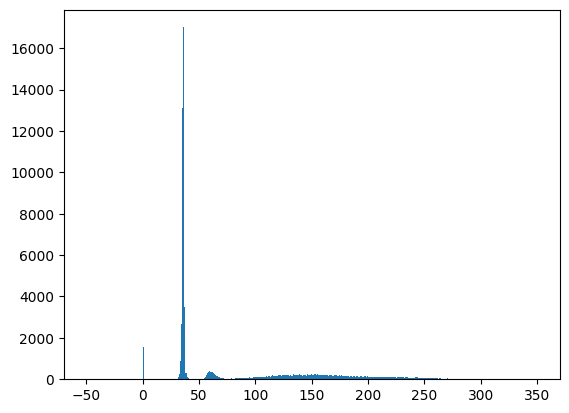

In [29]:
#adc spectrum
plt.hist(pd_mdt_chamber.rawMdt_adc, bins=400,range=(-50,350))
plt.show()

In [41]:
#plotting function for channel hitMap
def plothitMap(df_all, chamber):
    pd_mdt_chamber=df_all[df_all['rawMdt_station']==chamber]
    
    chamberinfo=list(pd_mdt_chamber.rawMdt_tubeinfo)
    ml=[int(x.split('_')[1]) for x in chamberinfo]
    ly=[int(x.split('_')[2]) for x in chamberinfo]
    nLayer=[(int(x.split('_')[1])-1)*4 + int(x.split('_')[2] for x in chamber)]

In [42]:
pd_mdt_chamber=df_raw[df_raw['rawMdt_station']=='BMG4A12']
chamberinfo=list(pd_mdt_chamber.rawMdt_tubeInfo)

len(chamberinfo)

chamberinfo #chamber, multi-layer, layer, tube
# BIS7A02/04/06/08/10/12/14/16
# Raw hit and TrkHit for BIS7A chambers to plot DriftTime and ADC
# both the raw hits and trk for all chambers
# report: slides, BIS... info about the noisy tubes
# 

['BMG4A12-1-4-41',
 'BMG4A12-1-4-1',
 'BMG4A12-1-3-42',
 'BMG4A12-1-3-40',
 'BMG4A12-1-2-43',
 'BMG4A12-1-1-43',
 'BMG4A12-1-1-22',
 'BMG4A12-1-1-22',
 'BMG4A12-1-1-1',
 'BMG4A12-1-4-37',
 'BMG4A12-1-4-24',
 'BMG4A12-1-3-54',
 'BMG4A12-1-1-54',
 'BMG4A12-1-1-22',
 'BMG4A12-2-4-42',
 'BMG4A12-2-3-42',
 'BMG4A12-2-3-20',
 'BMG4A12-2-2-42',
 'BMG4A12-2-1-41',
 'BMG4A12-1-3-54',
 'BMG4A12-1-2-32',
 'BMG4A12-1-1-7',
 'BMG4A12-1-4-24',
 'BMG4A12-1-4-1',
 'BMG4A12-1-3-54',
 'BMG4A12-1-1-22',
 'BMG4A12-1-4-1',
 'BMG4A12-1-3-54',
 'BMG4A12-1-2-7',
 'BMG4A12-1-2-1',
 'BMG4A12-1-1-22',
 'BMG4A12-1-1-1',
 'BMG4A12-1-3-23',
 'BMG4A12-1-2-1',
 'BMG4A12-1-1-54',
 'BMG4A12-1-1-1',
 'BMG4A12-1-1-1',
 'BMG4A12-1-4-15',
 'BMG4A12-1-3-54',
 'BMG4A12-2-4-54',
 'BMG4A12-2-4-53',
 'BMG4A12-2-4-52',
 'BMG4A12-2-4-51',
 'BMG4A12-2-4-49',
 'BMG4A12-2-3-54',
 'BMG4A12-2-3-53',
 'BMG4A12-2-3-52',
 'BMG4A12-2-3-51',
 'BMG4A12-2-3-50',
 'BMG4A12-2-3-48',
 'BMG4A12-2-2-51',
 'BMG4A12-2-2-50',
 'BMG4A12-2-2-49',
 'BM

In [43]:
#apply to ML-layer tube columns.  ????
ml=[int(x.split('-')[1]) for x in chamberinfo]

ly=[int(x.split('-')[2]) for x in chamberinfo]


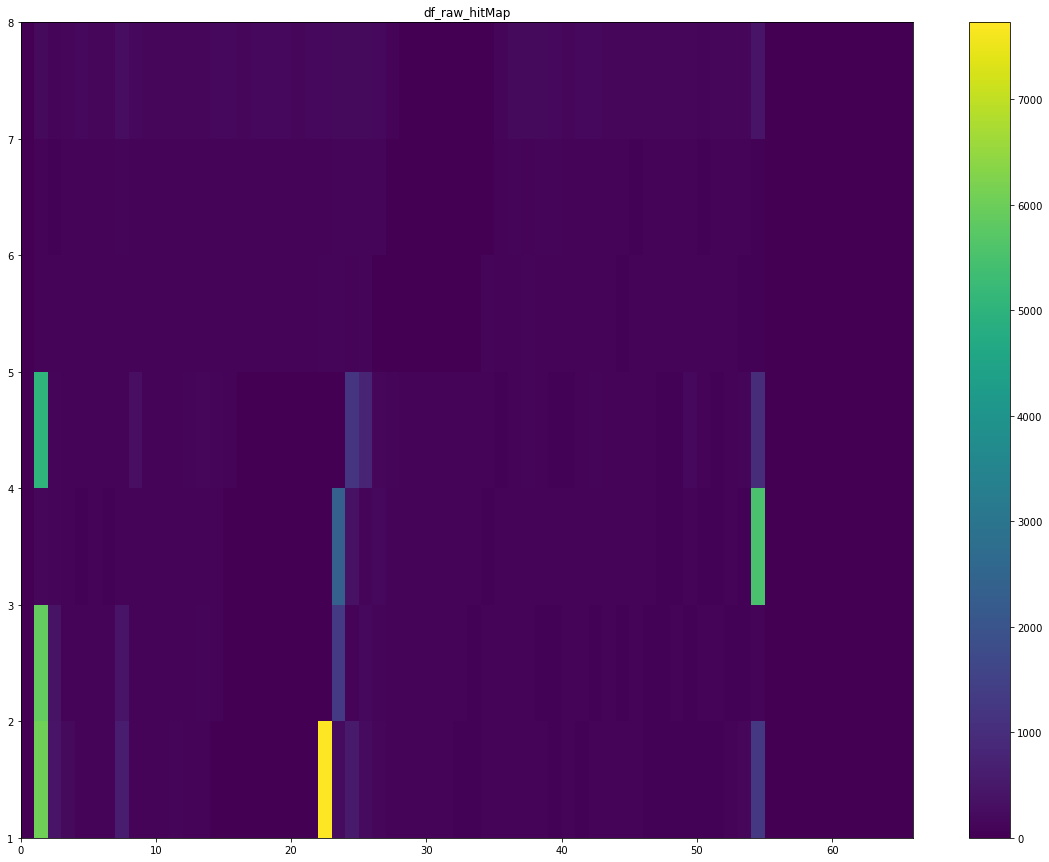

TypeError: savefig() missing 1 required positional argument: 'fname'

In [48]:
nLayer=[(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo]                                   
tb=[int(x.split('-')[3]) for x in chamberinfo]

fig,ax=plt.subplots(figsize=(20,15))
ax.set_title('df_raw_hitMap')

# get Maxtube per layer and total layer from chamberlist_run3.py
maxLy = chamberlist_run3.MDTtotalLayers('BMG4A12')
maxTb = chamberlist_run3.MDTtotalTubes('BMG4A12')

#plot hitogram
counts,xedges,yedges,im=ax.hist2d(tb,nLayer,bins=[66,7],range=[[0,66],[1,8]],cmap=plt.cm.viridis,label='hitMap')
fig.colorbar(im, ax=ax)
plt.show()
fig.savefig()


In [50]:
xedges # (22,1)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66.])

In [51]:
yedges

array([1., 2., 3., 4., 5., 6., 7., 8.])

In [53]:
type(counts)

numpy.ndarray

In [55]:
counts[22][0]

7730.0

In [59]:
counts[1][0]

6064.0